In [42]:
!pip install pulp
!pip install numpy matplotlib scikit-learn
!pip install gurobipy

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import pulp
from sklearn.datasets import make_blobs
from ucimlrepo import fetch_ucirepo
#from gurobipy import Model, GRB
from sklearn.cluster import KMeans

In [62]:
############################################# set up parameters ###################################################
beta = 1.5
epsilon = 0.25

k = 4
alpha = 3 + 2 * np.sqrt(2)
delta = np.sqrt(2)

In [63]:
################################################ useful helpers ###################################################
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def calculate_diameter(points):
    diameter = 0.0
    num_points = len(points)
    for i in range(num_points):
        for j in range(i+1, num_points):
            distance = euclidean_distance(points[i], points[j])
            if distance > diameter:
                diameter = distance
    return diameter

def cluster_and_sort(data, n_clusters):
    # Create a K-means model with specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)  # Fit the model to the data
    labels = kmeans.labels_  # Get the cluster assignments
    
    # Combine data and labels for sorting
    labeled_data = np.hstack((data, labels[:, np.newaxis]))
    
    # Sort data by cluster labels
    sorted_data = labeled_data[labeled_data[:, -1].argsort()]
    
    return sorted_data, labels, kmeans.cluster_centers_

In [64]:
############################### offline algorithm to produce offline OPT distance #################################
# greedy approximation to compute OPT_distance
def offline_k_center(points, k):
    # Initialize the first center randomly
    centers = [points[np.random.randint(len(points))]]
    
    while len(centers) < k:
        # Find the point that is the farthest from any center
        next_center = max(points, key=lambda point: min(euclidean_distance(point, center) for center in centers))
        centers.append(next_center)
    
    return centers

# LP relaxation for offline k-center's OPT_distance 
def lp_relaxation_k_center(points, k):
    num_points = len(points)
    prob = pulp.LpProblem("k_Center", pulp.LpMinimize)

    # populate distance matrix
    dist_mat = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            dist_mat[i, j] = euclidean_distance(points[i], points[j])
    #print("distance matrix:", dist_mat)

    # Variables
    x = pulp.LpVariable.dicts("x", (range(num_points), range(num_points)), lowBound=0, upBound=1, cat=pulp.LpContinuous)
    y = pulp.LpVariable.dicts("y", range(num_points), lowBound=0, upBound=1, cat=pulp.LpContinuous)
    z = pulp.LpVariable("z", lowBound=0, cat=pulp.LpContinuous)

    # Objective
    prob += z, "Maximum distance to nearest center"

    # Constraints
    for i in range(num_points):
        prob += pulp.lpSum(x[i][j] for j in range(num_points)) == 1, f"Assign_{i}"
        for j in range(num_points):
            prob += x[i][j] <= y[j], f"Link_{i}_{j}"
            prob += dist_mat[i][j] * x[i][j] <= z, f"Distance_{i}_{j}"

    prob += pulp.lpSum(y[j] for j in range(num_points)) == k, "Number_of_centers"

    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # print out the x matrix for debugging
    x_mat = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            x_mat [i, j] = x[i][j].varValue

    z = np.zeros(num_points)
    for i in range(num_points):
        for j in range(num_points):
            z[i] += x_mat[i][j] * dist_mat[i][j]
    
    result = np.max(z)
    
    return result

# used in conjunction with greedy approximation to calculate the max distance 
# from a point to its nearest center
def max_distance_to_centers(points, centers):
    if len(points) <= len(centers):
        return 0
    max_dist = 0
    for point in points:
        min_dist_to_center = min(euclidean_distance(point, center) for center in centers)
        max_dist = max(max_dist, min_dist_to_center)
    return max_dist

In [65]:
def plot_points_and_centers(points, centers):
    plt.figure(figsize=(8, 6))
    x, y = zip(*points)
    cx, cy = zip(*centers)
    
    plt.scatter(x, y, color='blue', label='Points')
    plt.scatter(cx, cy, color='red', s=100, label='Centers', edgecolors='black')
    plt.title("Offline k-Center Clustering")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_multiple_lines(x, y_list, labels, colors, title='Multiple Line Graph', x_label='X Axis', y_label='Y Axis'):
    plt.figure(figsize=(10, 5))  # Set the figure size
    for y, label, color in zip(y_list, labels, colors):
        plt.plot(x, y, label=label, color=color, marker='o')  # Plot each line with a specified label and color
    plt.title(title)  # Set the title of the graph
    plt.xlabel(x_label)  # Set the label for the x-axis
    plt.ylabel(y_label)  # Set the label for the y-axis
    plt.legend()  # Show legend
    plt.grid(True)  # Enable grid
    plt.show()

In [66]:
####################################### online update algorithm for k-center ##################################################

####################################### functions needed for main method ############################################################

# update the covering constraints to accommodate insertion and deletion of clients
# (potentially needed)
def update_constraints(C,s, n):
    # update the constraint matrix that for each client, Cx >= 1
    # where row t in C for client t has 0s at entries in s
    new_row = np.zeros(n)
    new_row[s] = 1
    C.append(new_row)
    
    return C

# find all points within the radius of the current client
# this step can be thought of as updating the covering constraint
def find_candidates(client_indices, points, client, radius):
    s = []
    for index in client_indices:
        if euclidean_distance(points[int(index)], client) <= radius:
            s.append(int(index))
    
    return s


# check if new client's constraint is satisfied
def check_covering_feasibility(s, x):
    # check if the covering constraint is satisfied
    covering_sum = np.sum(x[s])
    if covering_sum >= 1:
        return True
    else:
        return False


# alternative method to update x's when a covering violation occurs
# we use the closed form with the lagrange multiplier here
def update_covering(x, s, epsilon):
    d = len(s)
    log_term = (epsilon/4 + 1) / (np.sum(x[s]) + epsilon / 4)

    y = np.log(log_term)
    x[s] = (x[s] + epsilon / (4 * d)) * np.exp(y) - (epsilon / (4 * d))
    for i in s:
        x[i] = max(0, x[i])

    return x

# alternative method to update x's when a packing violation occurs
# similarly, we also use the closed form here
def update_packing(x, epsilon, k):
    log_term_bottom = 0
    for i in range(len(x)):
        if x[i] > 0:
            log_term_bottom += x[i]
    
    if log_term_bottom > 0:
        neg_z = np.log(((1 + epsilon) * k) / log_term_bottom)
        x = x * np.exp(neg_z)
    
    return x

In [67]:
############################ method used to compute OPT_rec at time t #################################

# arguments: 
#   C: a list of length T that consists of covering constraints at time t; 
#      C(t) is the indices of non-zero c_i's that appear in a covering constraint at time t: 
#   P: a list of packing contraints at each t defined similarly to C
#   t: index of current iteration (starts from 0)
def compute_OPT_rec(C_list, P_list, t, k, epsilon, client_indices):

    # Problem data and parameters
    T = t + 1  # Number of time periods
    n = t + 1  # Number of total variables (including removed clients)
    # Create the LP problem object
    lp_prob = pulp.LpProblem("OPT_recourse", pulp.LpMinimize)

    # Decision variables x_i^t and l_i^t
    x = pulp.LpVariable.dicts("x", (range(T), range(n)), lowBound=0, upBound=1, cat=pulp.LpContinuous)
    l = pulp.LpVariable.dicts("l", (range(T), range(n)), lowBound=0, cat=pulp.LpContinuous)
    #z = pulp.LpVariable("z", lowBound=0)

    # Objective function
    lp_prob += pulp.lpSum(l[t][i] for i in range(n) for t in range(T))

    # Constraints
    for t in range(len(C_list)):
        C_t = C_list[t]
        for c in range(len(C_t)):
            subset_indices = C_t[c]
            lp_prob += pulp.lpSum(x[t][i] for i in subset_indices) >= 1  
    for t in range(len(P_list)):
        P = P_list[t]
        
        #lp_prob += z <= (1 + epsilon) * k
        #lp_prob += z <= len(P)
        lp_prob += pulp.lpSum(x[t][i] for i in P) <= (1 + epsilon) * k  
        # make sure that removed points are set to 0
        for i in range(n):
            if i not in P:
                lp_prob += x[t][i] == 0
    
    for i in range(n):
        # include the recourse at t = 0
        lp_prob += x[0][i] <= l[0][i]
    for t in range(1, T):
        for i in range(n):
            lp_prob += (x[t][i] - x[t-1][i]) <= l[t][i] #, f"ChangeConstraint_Pos_{t}_{i}"
            lp_prob += (x[t-1][i] - x[t][i]) <= l[t][i] #, f"ChangeConstraint_Neg_{t}_{i}"

    # Solve the problem
    lp_prob.solve(pulp.PULP_CBC_CMD(msg=False))

    # Output results
    # printing x and l matrices for debugging
    x_mat = np.zeros((T, n))
    l_mat = np.zeros((T, n))

    for i in range(T):
        for j in range(n):
            x_mat [i, j] = x[i][j].varValue
            l_mat[i, j] = l[i][j].varValue
    
    # return the last row of the x matrix as the fractional solution for rounding
    return pulp.value(lp_prob.objective), x_mat[-1]

In [68]:
######################################### helper for rounding ###########################################

# subroutine to find the balls B_i and B_hait_i given the identifying index of a center
# this subroutine is called whenever the set S(t) is updated
def find_balls(data_points, client_indices, center_index, radius, radius_hat):

    B_i = []
    B_i_hat =[]

    for index in client_indices:
        if euclidean_distance(data_points[index], data_points[center_index]) <= radius:
            B_i.append(index)
            
        if euclidean_distance(data_points[index], data_points[center_index]) <= radius_hat:
            B_i_hat.append(index)
    
    return B_i, B_i_hat

In [74]:
###################################### main method for online k-center #######################################
def online_k_center(requests, points, k):

    total_recourse = 0
    total_integer_recourse = 0

    # initialize the vector x with all 0s of dimension len(points)
    x = np.zeros(len(points))

    # store each client as a tuple (index in points, coordinates)
    clients = []
    # the coordinates of active clients
    client_points = []
    client_indices = []

    set_of_centers = []
    radius_of_centers = np.zeros(len(x))

    # initialize variables needed for computing OPT_rec:
    # a t-by-n list of lists C, whose number of rows grows as t increases,
    # each row stores the covering constraints of time t
    # A matrix P for packing constraints is defined similarly
    C_list = []
    P_list = []
    
    dist_array = np.zeros(len(points))
    OPT_dist_array = np.zeros(len(points))
    
    OPT_rec_arr = np.zeros(len(points))
    rounding_rec_arr = np.zeros(len(points))

    t = 0  # for indexing the data points     
    for r in range(len(requests)):

        x_old = np.copy(x)

        # if requests[r] == 1, then the current request is a removal
        # remove the randomly sampled client from the set of active clients
        if requests[r] == -1:
            # random sample an active client to remove
            if len(client_indices) > 0:
                client_to_remove = random.randint(0, t)
                while client_to_remove in set_of_centers or client_to_remove not in client_indices:
                    client_to_remove = random.randint(0, t)
                
                x[client_to_remove] = 0
                if client_to_remove in client_indices:
                    client_indices.remove(client_to_remove)
                
                    item_to_remove = points[client_to_remove]
                    for i in range(len(client_points)):
                        if np.array_equal(client_points[i], item_to_remove):
                            client_points.pop(i)
                            break

                    for client in clients:
                        if client[0] == client_to_remove:
                            clients.remove(client)
            continue

        # otherwise, the request is an insertion, add the new client to the set of active clients
        current_client = (t, points[t])
        current_client_coordinates = points[t]
        clients.append(current_client)
        client_points.append(points[t])
        client_indices.append(t)

        # calculate OPT_dist at this round
        diam = calculate_diameter(client_points)
        centers_offline = offline_k_center(client_points, k)
        approx_dist = max_distance_to_centers(client_points, centers_offline)
        current_OPT_dist = lp_relaxation_k_center(client_points, k)
        current_OPT_dist = approx_dist 

        # stores all covering constraints at t for computing OPT_rec
        C_t =[]

        # find all points within min(beta * current_OPT_dist, diam) of the new client
        s = find_candidates(client_indices, points, current_client_coordinates, min(beta * current_OPT_dist, diam))
    
        # check if covering constraint is violated (for the new client)
        # if so, update the values of x's according to B_j(t) of each active client
        if check_covering_feasibility(s, x) == False:
            # covering constraint not satisfied, need to update values of x's in s
            # add the set s to C_list for computing OPT_rec
            x_new = update_covering(x, s, epsilon)
        else:
            t += 1

            center_coordinates = random.sample(list(points), len(set_of_centers))
            for i in range(len(set_of_centers)):
                center_coordinates[i] = points[set_of_centers[i]]
            max_online_dist = max_distance_to_centers(client_points, center_coordinates)
            if t < len(dist_array):
                dist_array[t] = max_online_dist 
                OPT_dist_array[t] = current_OPT_dist
            
            continue

        # check if packing constraint is violated
        # if so, update the values of x's
        if (np.sum(x_new) > (1+epsilon) * k):
            x_new = update_packing(x_new, epsilon, k)

        # record the packing constraint for this iteration
        # this is used to compute OPT_rec
        active_set = []
        active_set = copy.deepcopy(client_indices)
        P_list.append(active_set)

        # recheck again the covering constraint's for all points 
        # formulate a covering constraint matrix
        A_t = np.zeros((len(points), len(points)))
        for client_index in client_indices:
            s_set = find_candidates(client_indices, points, points[client_index], min(beta * current_OPT_dist, diam))
            C_t.append(s_set)
            A_t[client_index][s_set] = 1

        
        A_t_x = np.dot(A_t, x_new)
        while np.all(A_t_x[client_indices] >= 1 - 0.001) == False:
            for client_index in client_indices:
                s_set = find_candidates(client_indices, points, points[client_index], min(beta * current_OPT_dist, diam))
                x_new = update_covering(x_new, s_set, epsilon)
            A_t_x_new = np.dot(A_t, x_new)
            if (np.all(A_t_x_new - A_t_x == 0)):
                # avoid infinite loop
                break
            A_t_x = copy.deepcopy(A_t_x_new)
        
        for client_index in client_indices:
            s_set = find_candidates(client_indices, points, points[client_index], min(beta * current_OPT_dist, diam))
            if check_covering_feasibility(s_set, x_new) == False:
                update_covering(x_new, s_set, epsilon)
        
        
        # record all covering constraints for this round
        C_list.append(C_t)
    
        #OPT_recourse = 0
        OPT_recourse, x_OPT = compute_OPT_rec(C_list, P_list, t, k, epsilon, client_indices)
        OPT_rec_arr[t] = OPT_recourse

        # update total recourse in l1-norm
        total_recourse += np.sum(np.abs(x_new - x_old))
        x = x_new
        
        #################################### rounding procedure begins from here ####################################
        # integrate rounding at each round
        # maintain a set S (initially empty) of open centers at each t
        # r_i of each 'center' is stored at radius_of_centers[center]
        
        # identify the balls/set of points that are B_i and B_i_hat for each i in set_of_centers
        # while building the balls B_i, drop any i from set_of_centers if it has mass less than 1-epsilon

        S_prev = copy.deepcopy(set_of_centers)
        
        list_of_B_i_hat = []
        S = copy.deepcopy(set_of_centers)
        for center in S:

            if center not in client_indices: # this means 'center' was a removed point at some t
                set_of_centers.remove(center)
                #total_integer_recourse += 1
                continue
            
            B_i, B_i_hat = find_balls(data_points, client_indices, center, radius_of_centers[center], alpha * min(beta * current_OPT_dist, diam))
            
            # drop any B_i whose mass is too small
            mass = 0
            for index_of_point in B_i:
                mass += x[index_of_point]  

            if mass < 1 - epsilon:
                set_of_centers.remove(center)
                #total_integer_recourse += 1
            else:
                list_of_B_i_hat.append(B_i_hat)
        
        covered_points = set(item for sublist in list_of_B_i_hat for item in sublist)
        while len(covered_points) < len(client_indices):
        # find the clients that are not covered by the current set of centers
            uncovered = set(client_indices) - covered_points
            j = next(iter(uncovered))
            set_of_centers.append(j)
            set_of_centers = list(set(set_of_centers)) # get rid of (potential) duplicates in the list
            #total_integer_recourse += 1
            # record current_radius
            current_r = min(beta * current_OPT_dist, diam)
            radius_of_centers[j] = current_r

            S = copy.deepcopy(set_of_centers)
            for center_index in S:
                ball_dist = radius_of_centers[j] + radius_of_centers[center_index] + delta * min(radius_of_centers[j], radius_of_centers[center_index])
                if center_index != j and euclidean_distance(points[center_index], points[j]) <= ball_dist:
                    set_of_centers.remove(center_index)
                    #total_integer_recourse += 1
                    
            # update the the set of B_i_hats
            list_of_B_i_hat = []
            for center in set_of_centers:
                B_i, B_i_hat = find_balls(points, client_indices, center, radius_of_centers[center], alpha * min(beta * current_OPT_dist, diam))
                list_of_B_i_hat.append(B_i_hat)
            covered_points = set(item for sublist in list_of_B_i_hat for item in sublist)
        
        # compute rounding recourse this round
        diff = set(S_prev) ^ set(set_of_centers)
        total_integer_recourse += len(diff)
        
        center_coordinates = random.sample(list(points), len(set_of_centers))
        for i in range(len(set_of_centers)):
            center_coordinates[i] = points[set_of_centers[i]]
        max_online_dist = max_distance_to_centers(client_points, center_coordinates)
        if t < len(dist_array):
            dist_array[t] = max_online_dist 
            OPT_dist_array[t] = current_OPT_dist
            
        rounding_rec_arr[t] = total_integer_recourse

        t += 1
        #final_set = client_points

    return x, total_recourse, set_of_centers, OPT_recourse, total_integer_recourse, dist_array, OPT_dist_array, OPT_rec_arr, rounding_rec_arr

In [75]:
################################################### main starts here ############################################################

In [76]:
# Alternative method 1: generate random 2D points
# Generate random points
np.random.seed(42)
random_points = np.random.rand(100, 2) * 100  # 100 points in a 100x100 grid
#data_points = random_points

In [77]:
# Alternative Method 2: generate test points in clusters 
# Settings for the clusters
#n_samples = 200          # Total number of points
#n_features = 2           # Number of dimensions (2D)
#centers = 4              # Number of clusters
#cluster_std = 1        # Standard deviation of clusters
#cluster_points, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cluster_std, random_state=42)

In [90]:
# set this variable to one of random_points, cluster_points, or ucirepo_points
#data_points = random_points
#data_points = cluster_points

num_of_points = 100

data_list = [42, 186, 291]
Y_dist = np.zeros(num_of_points)
T = np.zeros(num_of_points-1)
for i in range(num_of_points-1):
    T[i] = i

# fetch dataset
#id_num = data_list[i]
id_num = 291
df = fetch_ucirepo(id=id_num) 
  
# data (as pandas dataframes) 
X = df.data.features 
y = df.data.targets 
  
# variable information 
print(df.variables) 

ucirepo_points = X.to_numpy()
data_points = ucirepo_points

data_points = random.sample(list(data_points), num_of_points)
#random.shuffle(data_points)

data_points, clusters, cluster_centers = cluster_and_sort(data_points, 4)
'''
for idx, point in enumerate(data_points):
    print(f"Data Point: {point[:-1]} - Cluster: {int(point[-1]) + 1}")
'''
data_points = data_points[:-1]
#print(data_points)

############################################## set up dynamic streaming ###############################################
# Preliminary simulation of dynamic streaming:
# We'll add 10 - 20% of the amout of data to be removal requests
# to simulate dynamic streaming.
# For simplicity, whenever we encounter a removal request,
# we randomly sample an active client point that is not in the set of centers
# In our request array. a +1 indicates an insertion of a client;
# -1 indicates a removal.
requests = np.ones(int(len(data_points)))
#removals = np.random.choice(range(0, len(data_points)+ 1), int(len(data_points)*0.1), replace=False)
#requests[removals] = -1
    
############################################ solve the offline problem #################################################
# Solve the offline k-center problem
# (optional) greedy approximation of k-center for 
approx_centers = offline_k_center(data_points, k)
max_dist_approx = max_distance_to_centers(data_points, approx_centers)

# Offline LP relaxation to get OPT_dist
# This value is used as OPT(t) in the online algorithm for each t
max_dist = lp_relaxation_k_center(data_points, k)
#print("Offline OPT max distance:", max_dist)
    
########################################### run online algorithm including rouding ######################################

fractional_sol, recourse, centers, OPT_rec, total_int_recourse, Y_dist, Y_OPT_dist, OPT_rec_arr, rounding_rec_arr = online_k_center(requests, data_points, k) 

# Output final results
print("\n-----------result for dataset:", id_num)
print("k = ", k)
print("beta = ", beta)
print("epsilon = ", epsilon)
print("alpha:", alpha)
print("number of centers (sum of fractional x's):", np.sum(fractional_sol))
print("OPT recourse:", OPT_rec)
print("total fractional online recourse:", recourse)
print("final selected centers:", centers)
print("total rounding recourse:", total_int_recourse)


center_coordinates = random.sample(list(data_points), len(centers))
for i in range(len(centers)):
    center_coordinates[i] = data_points[centers[i]]
max_online_dist = max_distance_to_centers(data_points, center_coordinates)

print("Offline OPT max distance:", max_dist)
print("max online distance:", max_online_dist)
print("alpha * beta * offline max distance:", alpha * beta * max_dist)

# Plot the points and the selected centers
#plot_points_and_centers(data_points, center_coordinates)

                                  name     role        type demographic  \
0                            frequency  Feature     Integer        None   
1                         attack-angle  Feature      Binary        None   
2                         chord-length  Feature  Continuous        None   
3                 free-stream-velocity  Feature  Continuous        None   
4  suction-side-displacement-thickness  Feature  Continuous        None   
5                scaled-sound-pressure   Target  Continuous        None   

  description units missing_values  
0        None    Hz             no  
1        None   deg             no  
2        None     m             no  
3        None   m/s             no  
4        None     m             no  
5        None    dB             no  


/Users/yueyang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



-----------result for dataset: 291
k =  4
beta =  1.5
epsilon =  0.25
alpha: 5.82842712474619
number of centers (sum of fractional x's): 4.000973984356055
OPT recourse: 13.0
total fractional online recourse: 18.50693696858715
final selected centers: [0, 72]
total rounding recourse: 14
Offline OPT max distance: 3371.0533683809695
max online distance: 9000.064844003045
alpha * beta * offline max distance: 29471.908336857974


OPT recourse at each t: [ 1.  2.  3.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  7.  9. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
 13. 13. 13. 13. 13. 13. 13. 13. 13.]
rounding recourse at each t: [ 1.  2.  3.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14.]


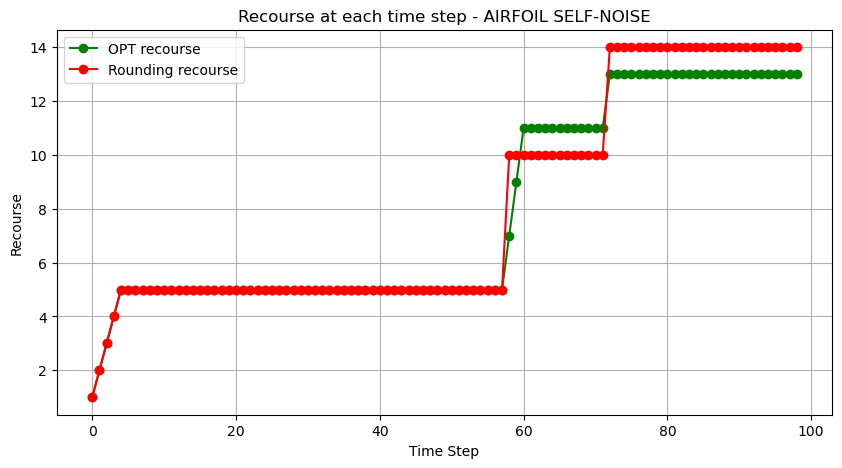

In [91]:

for i in range(len(OPT_rec_arr)):
    if OPT_rec_arr[i] == 0:
        OPT_rec_arr[i] = OPT_rec_arr[i-1]
    if rounding_rec_arr[i] == 0:
        rounding_rec_arr[i] = rounding_rec_arr[i-1]

print("OPT recourse at each t:", OPT_rec_arr)
print("rounding recourse at each t:", rounding_rec_arr)

plot_multiple_lines(T, [OPT_rec_arr, rounding_rec_arr], 
                    labels=['OPT recourse', 'Rounding recourse'],
                    colors=['green', 'red'],
                    title='Recourse at each time step - AIRFOIL SELF-NOISE',
                    x_label='Time Step', 
                    y_label='Recourse')


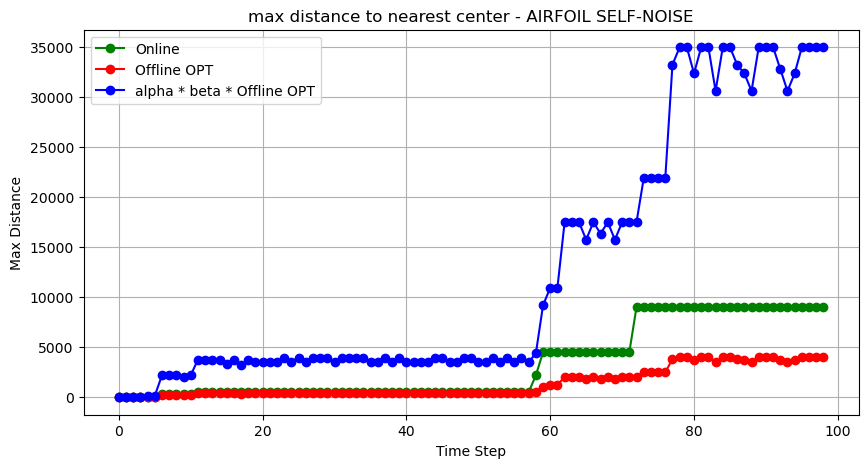

In [92]:
for i in range(len(Y_dist)):
    if Y_dist[i] == 0 and i >= (1 + epsilon) * k:
        Y_dist[i] = Y_dist[i-1]
    
    if Y_OPT_dist[i] == 0 and i > k:
        Y_OPT_dist[i] = Y_OPT_dist[i-1]

Y_bound = np.zeros(len(Y_OPT_dist))
Y_bound = beta * alpha * Y_OPT_dist

#print("online dist:", Y_dist)
#print("offline dist:", Y_OPT_dist)
#print("beta * alpha dist:", Y_bound)

plot_multiple_lines(T, [Y_dist, Y_OPT_dist, Y_bound], 
                    labels=['Online', 'Offline OPT', 'alpha * beta * Offline OPT'],
                    colors=['green', 'red', 'blue'],
                    title='max distance to nearest center - AIRFOIL SELF-NOISE',
                    x_label='Time Step', 
                    y_label='Max Distance')